In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### Create graph with navigation information

In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.4042418779,0],
    [0.79950060287,0], 
    [1.10492779947,0],
    [1.25764139777,0],
    [1.27560770345,0],
    [1.527135983,0],
    [1.69781588699,0], 
    [2.03019254211,0],
    [2.16493983473,0],
    [2.34460289155,0],
    [3.0093562018,0],
    [3.27885078704,0], 
    [3.36868231545,0],
    [4.06038508422,0],
    [4.06936823706,0], 
    [4.4915764206,0],
    [4.54547533765,0],
    [4.68022263026,0], 
    [5.04853189675,0],
    [5.2102286479,0],
    [6.5846510326,0], 
] 


# for each edge (between above coordinates) specify the depth (m)
depths = [
            7.5, 4.18, 4.18, 7.83,7.83, 
            7.5, 6.5, 10.6, 6.45, 8.04,
            8.04, 5.65, 8.87, 8.87, 4.93,
            4.93, 7.7,7.7, 9.8, 5.45, 5.45
         ] # [m]

current_speeds = [
                    -2.24* 0.2777, -3.4* 0.2777, -4.93* 0.2777, -2.59* 0.2777, -2.59* 0.2777,
                    -3.26* 0.2777, -3.85* 0.2777, -1.87* 0.2777, -1.08* 0.2777, -2.83* 0.2777, 
                    -2.83* 0.2777, -4.99* 0.2777,  -2.89* 0.2777,  -2.89* 0.2777, -6.4* 0.2777,
                    -6.4* 0.2777, -3.42* 0.2777, -3.42* 0.2777, -1.64* 0.2777, -4.1* 0.2777, -4.1* 0.2777
                ]  # [m/s]

V_g_profile_up = [
                    3.33, 3.33, 3.33, 3.33, 3.33,   
                    3.33, 3.33, 3.33, 3.33, 3.33,
                    3.33, 3.33, 3.33, 3.33, 3.33,
                    3.33, 3.33, 3.33, 3.33, 3.33, 3.33
                ] # [m/s] for upstream, 3.33 m/s = 12 km/h

V_g_profile_down = [
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 3.33, 4.44, 4.44
                    ] # [m/s] for downstream, 4.44 m/s = 16 km/h


# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

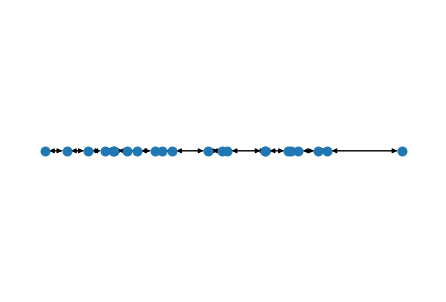

In [4]:
# show graph
nx.draw(FG, positions, node_size=80)

plt.show()

### Define the path 1 on the graph for energy use simulation

In [5]:
path_up_1_Budapest2Regensburg = nx.dijkstra_path(FG, nodes[21].name, nodes[0].name)

### Create vessel sailing on path 1 - add VesselProperties and ConsumesEnergy mixins

In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

vessels sailing on path 1 include 17 vessel types sailing upstream loaded and ballast

In [7]:
# Create a dict with all important settings

data_vessel_MCV135_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV135_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 135,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1800,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [8]:
# Create a dict with all important settings

data_vessel_MCV135_up_ballast = {
    "env": None,
    "name": 'MCV135_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 135,
    "T": 1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1800,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [9]:
# Create a dict with all important settings

data_vessel_MCV110_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV110_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [10]:
# Create a dict with all important settings

data_vessel_MCV110_up_ballast = {
    "env": None,
    "name": 'MCV110_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [11]:
# Create a dict with all important settings

data_vessel_MCV110_1B_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV110_1B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 186.5,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [12]:
# Create a dict with all important settings

data_vessel_MCV110_1B_up_ballast = {
    "env": None,
    "name": 'MCV110_1B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 186.5,
    "T": 1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [13]:
# Create a dict with all important settings

data_vessel_MCV105_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV105_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 105,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":950,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [14]:
# Create a dict with all important settings

data_vessel_MCV105_up_ballast = {
    "env": None,
    "name": 'MCV105_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 105,
    "T": 1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 950,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [15]:
# Create a dict with all important settings

data_vessel_MCV95_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV95_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11,
    "L": 95,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1300,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [16]:
# Create a dict with all important settings

data_vessel_MCV95_up_ballast = {
    "env": None,
    "name": 'MCV95_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11,
    "L": 95,
    "T": 1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1300,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [17]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV85_9_5_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [18]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_up_ballast = {
    "env": None,
    "name": 'MCV85_9_5_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [19]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_1B_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV135_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 161.5,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [20]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_1B_up_ballast = {
    "env": None,
    "name": 'MCV135_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 161.5,
    "T": 1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [21]:
# Create a dict with all important settings

data_vessel_MCV85_8_2_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV85_8_2_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [22]:
# Create a dict with all important settings

data_vessel_MCV85_8_2_up_ballast = {
    "env": None,
    "name": 'MCV85_8_2_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 85,
    "T": 1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [23]:
# Create a dict with all important settings

data_vessel_MCV80_8_2_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV80_8_2_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 135,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [24]:
# Create a dict with all important settings

data_vessel_MCV80_8_2_up_ballast = {
    "env": None,
    "name": 'MCV80_8_2_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 135,
    "T": 1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [25]:
# Create a dict with all important settings

data_vessel_MTV110_up_loaded_MHWL = {
    "env": None,
    "name": 'MTV110_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [26]:
# Create a dict with all important settings

data_vessel_MTV110_up_ballast = {
    "env": None,
    "name": 'MTV110_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [27]:
# Create a dict with all important settings

data_vessel_MTV110_1B_up_loaded_MHWL = {
    "env": None,
    "name": 'MTV110_1B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 186.5,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [28]:
# Create a dict with all important settings

data_vessel_MTV110_1B_up_ballast = {
    "env": None,
    "name": 'MTV110_1B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 186.5,
    "T": 1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [29]:
# Create a dict with all important settings

data_vessel_MTV85_up_loaded_MHWL = {
    "env": None,
    "name": 'MTV85_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [30]:
# Create a dict with all important settings

data_vessel_MTV85_up_ballast = {
    "env": None,
    "name": 'MTV85_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [31]:
# Create a dict with all important settings

data_vessel_PUSH23_1B_up_loaded_MHWL = {
    "env": None,
    "name": 'PUSH23_1B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 99.5,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [32]:
# Create a dict with all important settings

data_vessel_PUSH23_1B_up_ballast = {
    "env": None,
    "name": 'PUSH23_1B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 99.5,
    "T": 1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [33]:
# Create a dict with all important settings

data_vessel_PUSH23_2B_up_loaded_MHWL = {
    "env": None,
    "name": 'PUSH23_2B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 176,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [34]:
# Create a dict with all important settings

data_vessel_PUSH23_2B_up_ballast = {
    "env": None,
    "name": 'PUSH23_2B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 176,
    "T": 1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [35]:
# Create a dict with all important settings

data_vessel_PUSH35_2B_up_loaded_MHWL = {
    "env": None,
    "name": 'PUSH35_2B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 188,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1700,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [36]:
# Create a dict with all important settings

data_vessel_PUSH35_2B_up_ballast = {
    "env": None,
    "name": 'PUSH35_2B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 188,
    "T": 1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1700,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [37]:
# Create a dict with all important settings

data_vessel_PUSH35_4B_up_loaded_MHWL = {
    "env": None,
    "name": 'PUSH35_4B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 188,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":2500,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [38]:
# Create a dict with all important settings

data_vessel_PUSH35_4B_up_ballast = {
    "env": None,
    "name": 'PUSH35_4B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 188,
    "T": 1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 2500,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [39]:
# Create a dict with all important settings

data_vessel_PUSH57_2B_up_loaded_MHWL = {
    "env": None,
    "name": 'PUSH57_2B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 210,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1470,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [40]:
# Create a dict with all important settings

data_vessel_PUSH57_2B_up_ballast = {
    "env": None,
    "name": 'PUSH57_2B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 210,
    "T": 1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1470,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



### Define simulation

define basic simulation for vessel moving and consuming energy

In [41]:
def run_simulation(path,**data_vessel):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    # vessel.V_g_ave = V_g_ave
    # vessel.sailing_upstream = sailing_upstream
    # vessel.P_tot_given = P_tot_given
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

define specific vessel simulation with vessel type and number of trips

In [42]:
def get_energy(nr_trips, path,**data_vessel):
    vessel = run_simulation(path,**data_vessel)
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel=vessel)
    energycalculation.calculate_energy_consumption()
    
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    
    selected = ['edge_start','edge_stop','distance','total_energy','total_H2_350bar_PEMFC_mass','total_H2_350bar_PEMFC_20ft_containers']
    df_energy = df[selected]
    df_energy['distance_km_cum']=df_energy['distance'].cumsum()/1000
    df_energy['total_trips_energy'] = df_energy['total_energy']*nr_trips
    df_energy['total_trips_H2_350bar_PEMFC_mass_ton'] = df_energy['total_H2_350bar_PEMFC_mass']*nr_trips/1000000
    df_energy['total_trips_H2_350bar_PEMFC_20ft_containers'] = df_energy['total_H2_350bar_PEMFC_20ft_containers']*nr_trips
    df_energy['energy_consumption_kWh_cum'] = df_energy['total_energy'].cumsum()
    df_energy['total_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_H2_350bar_PEMFC_mass'].cumsum()/1000000
    df_energy['total_H2_350bar_PEMFC_20ft_containers_cum'] = df_energy['total_H2_350bar_PEMFC_20ft_containers'].cumsum()
    df_energy['total_trips_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_trips_H2_350bar_PEMFC_mass_ton'].cumsum()
    df_energy['total_trips_H2_350bar_PEMFC_20ft_containers_cum'] = df_energy['total_trips_H2_350bar_PEMFC_20ft_containers'].cumsum()
    
    return df_energy

In [43]:
energy_MCV135_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV135_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV135_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,9505.829253,678761.247997,1.862171,153.0,161599.097309,11.538941,31.656903,9505.829253,0.678761,1.862171,11.538941,31.656903
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,1118.332853,79854.264476,0.219079,171.0,19011.658508,1.357522,3.724342,10624.162107,0.758616,2.081250,12.896464,35.381245
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,1228.474044,81980.249863,0.224912,212.0,20884.058751,1.393664,3.823496,11852.636151,0.840596,2.306161,14.290128,39.204741
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,684.798191,47069.878992,0.129135,227.0,11641.569246,0.800188,2.195303,12537.434342,0.887666,2.435297,15.090316,41.400044
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,273.919276,18827.951601,0.051654,233.0,4656.627700,0.320075,0.878121,12811.353619,0.906494,2.486951,15.410391,42.278165
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,6253.329759,514676.856031,1.412008,280.0,106306.605908,8.749507,24.004133,19064.683378,1.421170,3.898959,24.159898,66.282298
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,133.049569,10950.571405,0.030043,281.0,2261.842679,0.186160,0.510726,19197.732947,1.432121,3.929001,24.346057,66.793024
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,3032.541876,203864.749126,0.559300,358.0,51553.211890,3.465701,9.508095,22230.274823,1.635986,4.488301,27.811758,76.301120
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,393.836607,26475.941447,0.072636,368.0,6695.222324,0.450091,1.234818,22624.111430,1.662462,4.560937,28.261849,77.535937
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,2197.541839,156914.899424,0.430494,398.0,37358.211265,2.667553,7.318390,24821.653270,1.819377,4.991431,30.929402,84.854328


In [44]:
energy_MCV135_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV135_up_ballast)
# pd.options.display.max_columns = None
energy_MCV135_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,19062.775095,1.513827e+06,4.153161,153.0,324067.176607,25.735064,70.603743,19062.775095,1.513827,4.153161,25.735064,70.603743
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,2242.679423,1.780973e+05,0.488607,171.0,38125.550192,3.027655,8.306323,21305.454518,1.691925,4.641769,28.762719,78.910066
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,2719.462134,1.941825e+05,0.532737,212.0,46230.856271,3.301102,9.056522,24024.916651,1.886107,5.174505,32.063821,87.966588
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,1515.386353,1.164945e+05,0.319601,227.0,25761.567993,1.980407,5.433216,25540.303004,2.002602,5.494106,34.044228,93.399804
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,606.154541,4.659782e+04,0.127840,233.0,10304.627200,0.792163,2.173286,26146.457545,2.049199,5.621946,34.836391,95.573090
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,7057.057058,5.886768e+05,1.615025,280.0,119969.969978,10.007505,27.455432,33203.514602,2.637876,7.236972,44.843896,123.028522
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,150.150150,1.252504e+04,0.034362,281.0,2552.552553,0.212926,0.584158,33353.664753,2.650401,7.271334,45.056822,123.612681
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,6859.336478,5.126765e+05,1.406520,358.0,116608.720120,8.715500,23.910837,40213.001230,3.163078,8.677854,53.772322,147.523517
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,890.822919,6.658136e+04,0.182665,368.0,15143.989627,1.131883,3.105303,41103.824149,3.229659,8.860519,54.904205,150.628821
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,4495.247333,3.749789e+05,1.028749,398.0,76419.204655,6.374642,17.488729,45599.071482,3.604638,9.889268,61.278847,168.117549


In [45]:
energy_MCV110_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV110_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV110_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,8102.391231,605584.129344,1.661411,153.0,137740.650919,10.294930,28.243979,8102.391231,0.605584,1.661411,10.294930,28.243979
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,953.222498,71245.191692,0.195460,171.0,16204.782462,1.211168,3.322821,9055.613728,0.676829,1.856871,11.506098,31.566800
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,1054.385312,71126.010828,0.195133,212.0,17924.550307,1.209142,3.317263,10109.999040,0.747955,2.052004,12.715241,34.884062
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,584.991830,41771.188411,0.114599,227.0,9944.861114,0.710110,1.948176,10694.990871,0.789727,2.166602,13.425351,36.832238
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,233.996732,16708.475369,0.045839,233.0,3977.944446,0.284044,0.779270,10928.987603,0.806435,2.212442,13.709395,37.611509
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,4508.675342,376099.044238,1.031822,280.0,76647.480820,6.393684,17.540971,15437.662945,1.182534,3.244263,20.103079,55.152479
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,95.929263,8002.107324,0.021954,281.0,1630.797464,0.136036,0.373212,15533.592208,1.190536,3.266217,20.239115,55.525691
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,2594.385287,178496.594072,0.489703,358.0,44104.549872,3.034442,8.324944,18127.977494,1.369033,3.755920,23.273557,63.850635
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,336.933154,23181.375856,0.063598,368.0,5727.863620,0.394083,1.081162,18464.910648,1.392214,3.819517,23.667640,64.931797
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1879.426973,141008.322808,0.386854,398.0,31950.258542,2.397141,6.576520,20344.337622,1.533222,4.206372,26.064781,71.508317


In [46]:
energy_MCV110_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV110_up_ballast)
# pd.options.display.max_columns = None
energy_MCV110_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,9104.491745,680482.532825,1.866893,153.0,154776.359665,11.568203,31.737183,9104.491745,0.680483,1.866893,11.568203,31.737183
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,1071.116676,80056.768573,0.219634,171.0,18208.983491,1.360965,3.733786,10175.608421,0.760539,2.086528,12.929168,35.470969
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,1222.117444,84002.733870,0.230460,212.0,20775.996543,1.428046,3.917823,11397.725865,0.844542,2.316988,14.357215,39.388792
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,709.773994,50681.226101,0.139043,227.0,12066.157891,0.861581,2.363733,12107.499858,0.895223,2.456031,15.218795,41.752525
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,283.909597,20272.490445,0.055617,233.0,4826.463157,0.344632,0.945493,12391.409456,0.915496,2.511648,15.563428,42.698019
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,4508.675342,376099.044238,1.031822,280.0,76647.480820,6.393684,17.540971,16900.084798,1.291595,3.543470,21.957112,60.238989
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,95.929263,8002.107324,0.021954,281.0,1630.797464,0.136036,0.373212,16996.014061,1.299597,3.565424,22.093147,60.612201
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,3167.897718,226202.906823,0.620584,358.0,53854.261214,3.845449,10.549930,20163.911779,1.525800,4.186008,25.938597,71.162131
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,411.415288,29377.000889,0.080595,368.0,6994.059899,0.499409,1.370121,20575.327067,1.555177,4.266603,26.438006,72.532252
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,2201.193389,174802.811650,0.479569,398.0,37420.287608,2.971648,8.152669,22776.520456,1.729980,4.746172,29.409654,80.684921


In [47]:
energy_MCV110_1B_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV110_1B_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV110_1B_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,14658.238967,1.222743e+06,3.354575,153.0,249190.062439,20.786625,57.027778,14658.238967,1.222743,3.354575,20.786625,57.027778
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,1724.498702,1.438521e+05,0.394656,171.0,29316.477936,2.445485,6.709150,16382.737669,1.366595,3.749231,23.232110,63.736929
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,1818.945759,1.298813e+05,0.356327,212.0,30922.077909,2.207983,6.057566,18201.683428,1.496476,4.105559,25.440093,69.794495
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,1037.500375,8.239075e+04,0.226038,227.0,17637.506369,1.400643,3.842641,19239.183803,1.578867,4.331596,26.840736,73.637136
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,415.000150,3.295630e+04,0.090415,233.0,7055.002549,0.560257,1.537057,19654.183953,1.611823,4.422011,27.400993,75.174193
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,4508.675342,3.760990e+05,1.031822,280.0,76647.480820,6.393684,17.540971,24162.859295,1.987922,5.453833,33.794677,92.715163
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,95.929263,8.002107e+03,0.021954,281.0,1630.797464,0.136036,0.373212,24258.788558,1.995924,5.475787,33.930713,93.088375
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,4565.438133,3.412273e+05,0.936152,358.0,77612.448253,5.800864,15.914578,28824.226691,2.337152,6.411938,39.731577,109.002953
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,592.914043,4.431523e+04,0.121578,368.0,10079.538735,0.753359,2.066828,29417.140734,2.381467,6.533517,40.484935,111.069782
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,2877.877878,2.400632e+05,0.658610,398.0,48923.923922,4.081075,11.196364,32295.018612,2.621530,7.192126,44.566010,122.266146


In [48]:
energy_MCV110_1B_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV110_1B_up_ballast)
# pd.options.display.max_columns = None
energy_MCV110_1B_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,14677.177177,1.224322e+06,3.358909,153.0,249512.012012,20.813481,57.101457,14677.177177,1.224322,3.358909,20.813481,57.101457
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,1726.726727,1.440379e+05,0.395166,171.0,29354.354356,2.448645,6.717818,16403.903904,1.368360,3.754075,23.262126,63.819276
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,3933.099766,3.280864e+05,0.900100,212.0,66862.696028,5.577469,15.301698,20337.003670,1.696447,4.654175,28.839595,79.120973
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,1438.938939,1.200316e+05,0.329305,227.0,24461.961958,2.040537,5.598182,21775.942609,1.816478,4.983480,30.880132,84.719155
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,575.575576,4.801264e+04,0.131722,233.0,9784.784785,0.816215,2.239273,22351.518185,1.864491,5.115202,31.696347,86.958428
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,4508.675342,3.760990e+05,1.031822,280.0,76647.480820,6.393684,17.540971,26860.193527,2.240590,6.147023,38.090031,104.499399
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,95.929263,8.002107e+03,0.021954,281.0,1630.797464,0.136036,0.373212,26956.122790,2.248592,6.168977,38.226067,104.872611
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,7386.553220,6.161623e+05,1.690431,358.0,125571.404735,10.474758,28.737335,34342.676009,2.864754,7.859409,48.700825,133.609946
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,959.292626,8.002107e+04,0.219537,368.0,16307.974642,1.360358,3.732121,35301.968635,2.944775,8.078945,50.061183,137.342067
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,2877.877878,2.400632e+05,0.658610,398.0,48923.923922,4.081075,11.196364,38179.846513,3.184839,8.737555,54.142258,148.538431


In [49]:
energy_MCV105_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV105_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV105_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,7848.199435,586585.476658,1.609288,153.0,133419.390403,9.971953,27.357896,7848.199435,0.586585,1.609288,9.971953,27.357896
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,923.317581,69010.056082,0.189328,171.0,15696.398872,1.173171,3.218576,8771.517016,0.655596,1.798616,11.145124,30.576472
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,1021.535858,70215.677921,0.192636,212.0,17366.109584,1.193667,3.274805,9793.052874,0.725811,1.991252,12.338791,33.851277
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,566.895577,40479.030210,0.111054,227.0,9637.224814,0.688144,1.887911,10359.948451,0.766290,2.102305,13.026934,35.739188
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,226.758231,16191.612088,0.044421,233.0,3854.889926,0.275257,0.755164,10586.706682,0.782482,2.146727,13.302192,36.494353
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,3724.557891,310690.514805,0.852375,280.0,63317.484155,5.281739,14.490367,14311.264574,1.093172,2.999101,18.583930,50.984719
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,79.245913,6610.436485,0.018136,281.0,1347.180514,0.112377,0.308306,14390.510486,1.099783,3.017237,18.696308,51.293025
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,2513.411425,179469.484480,0.492372,358.0,42727.994228,3.050981,8.370319,16903.921912,1.279252,3.509608,21.747289,59.663344
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,326.417068,23307.725259,0.063944,368.0,5549.090160,0.396231,1.087054,17230.338980,1.302560,3.573553,22.143520,60.750398
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1823.744243,144828.538505,0.397335,398.0,31003.652136,2.462085,6.754692,19054.083223,1.447389,3.970888,24.605605,67.505090


In [50]:
energy_MCV105_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV105_up_ballast)
# pd.options.display.max_columns = None
energy_MCV105_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,8255.327983,640826.112255,1.758096,153.0,140340.575712,10.894044,29.887638,8255.327983,0.640826,1.758096,10.894044,29.887638
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,971.215057,75391.307329,0.206835,171.0,16510.655967,1.281652,3.516193,9226.543040,0.716217,1.964931,12.175696,33.403830
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,1107.703027,76138.412960,0.208885,212.0,18830.951466,1.294353,3.551037,10334.246067,0.792356,2.173816,13.470049,36.954867
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,642.020510,47561.710610,0.130485,227.0,10914.348666,0.808549,2.218242,10976.266577,0.839918,2.304301,14.278598,39.173109
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,256.808204,19024.684248,0.052194,233.0,4365.739468,0.323420,0.887297,11233.074781,0.858942,2.356494,14.602018,40.060406
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,3724.557891,310690.514805,0.852375,280.0,63317.484155,5.281739,14.490367,14957.632673,1.169633,3.208869,19.883757,54.550773
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,79.245913,6610.436485,0.018136,281.0,1347.180514,0.112377,0.308306,15036.878585,1.176243,3.227005,19.996134,54.859078
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,2866.262324,204664.710486,0.561494,358.0,48726.459507,3.479300,9.545405,17903.140909,1.380908,3.788499,23.475434,64.404483
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,372.241860,26579.832533,0.072921,368.0,6328.111625,0.451857,1.239663,18275.382769,1.407488,3.861420,23.927291,65.644146
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1998.666380,158719.585770,0.435445,398.0,33977.328468,2.698233,7.402560,20274.049150,1.566207,4.296865,26.625524,73.046706


In [51]:
energy_MCV95_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV95_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV95_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,6642.050387,474273.868116,1.301163,153.0,112914.856573,8.062656,22.119769,6642.050387,0.474274,1.301163,8.062656,22.119769
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,781.417693,55796.925665,0.153078,171.0,13284.100774,0.948548,2.602326,7423.468079,0.530071,1.454241,9.011203,24.722095
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,872.788959,58244.174774,0.159792,212.0,14837.412303,0.990151,2.716464,8296.257038,0.588315,1.614033,10.001354,27.438558
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,484.990286,33300.215113,0.091359,227.0,8244.834870,0.566104,1.553096,8781.247325,0.621615,1.705391,10.567458,28.991655
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,193.996115,13320.086048,0.036543,233.0,3297.933949,0.226441,0.621239,8975.243439,0.634935,1.741935,10.793900,29.612893
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,4676.992975,390139.554150,1.070342,280.0,79508.880578,6.632372,18.195809,13652.236414,1.025075,2.812277,17.426272,47.808702
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,99.510489,8300.841578,0.022773,281.0,1691.678310,0.141114,0.387145,13751.746903,1.033376,2.835050,17.567386,48.195847
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,2172.759597,145883.897026,0.400230,358.0,36936.913156,2.480026,6.803913,15924.506501,1.179260,3.235280,20.047413,54.999760
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,282.176571,18945.960654,0.051978,368.0,4797.001709,0.322081,0.883625,16206.683072,1.198206,3.287258,20.369494,55.883385
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1539.600304,109934.756451,0.301604,398.0,26173.205170,1.868891,5.127273,17746.283376,1.308140,3.588862,22.238385,61.010658


In [52]:
energy_MCV95_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV95_up_ballast)
# pd.options.display.max_columns = None
energy_MCV95_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,6741.139975,481349.334243,1.320574,153.0,114599.379581,8.182939,22.449763,6741.139975,0.481349,1.320574,8.182939,22.449763
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,793.075291,56629.333444,0.155362,171.0,13482.279952,0.962699,2.641149,7534.215267,0.537979,1.475936,9.145637,25.090912
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,913.125391,60935.962048,0.167177,212.0,15523.131652,1.035911,2.842006,8447.340658,0.598915,1.643113,10.181549,27.932918
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,523.491048,35982.367654,0.098717,227.0,8899.347813,0.611700,1.678190,8970.831706,0.634897,1.741830,10.793249,29.611108
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,209.396419,14392.947065,0.039487,233.0,3559.739126,0.244680,0.671276,9180.228125,0.649290,1.781317,11.037929,30.282384
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,4460.818989,363257.124739,0.996590,280.0,75833.922806,6.175371,16.942033,13641.047114,1.012547,2.777907,17.213300,47.224417
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,94.911042,7728.874994,0.021204,281.0,1613.487719,0.131391,0.360469,13735.958156,1.020276,2.799111,17.344691,47.584886
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,2344.296499,159329.576726,0.437118,358.0,39853.040478,2.708603,7.431009,16080.254655,1.179606,3.236229,20.053294,55.015895
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,304.454091,20692.152823,0.056769,368.0,5175.719543,0.351767,0.965066,16384.708745,1.200298,3.292998,20.405060,55.980961
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1624.821664,116019.965322,0.318299,398.0,27621.968286,1.972339,5.411082,18009.530409,1.316318,3.611297,22.377400,61.392044


In [53]:
energy_MCV85_9_5_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_9_5_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV85_9_5_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,5393.938634,403150.568542,1.106037,153.0,91696.956771,6.853560,18.802633,5393.938634,0.403151,1.106037,6.853560,18.802633
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,634.581016,47429.478655,0.130122,171.0,10787.877268,0.806301,2.212074,6028.519649,0.450580,1.236159,7.659861,21.014707
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,714.555797,48502.212344,0.133065,212.0,12147.448547,0.824538,2.262106,6743.075446,0.499082,1.369224,8.484398,23.276813
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,395.470504,28238.467726,0.077472,227.0,6722.998561,0.480054,1.317020,7138.545950,0.527321,1.446696,8.964452,24.593834
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,158.188201,11295.387093,0.030989,233.0,2689.199425,0.192022,0.526808,7296.734151,0.538616,1.477685,9.156474,25.120642
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,2940.440441,245281.985373,0.672927,280.0,49987.487491,4.169794,11.439763,10237.174592,0.783898,2.150612,13.326268,36.560405
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,62.562563,5218.765646,0.014318,281.0,1063.563564,0.088719,0.243399,10299.737155,0.789117,2.164930,13.414987,36.803804
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,1775.351511,123786.279826,0.339606,358.0,30180.975690,2.104367,5.773297,12075.088666,0.912903,2.504535,15.519353,42.577101
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,230.565131,16076.140239,0.044105,368.0,3919.607233,0.273294,0.749779,12305.653797,0.928979,2.548640,15.792648,43.326880
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1252.506788,95642.694038,0.262394,398.0,21292.615388,1.625926,4.460702,13558.160585,1.024622,2.811034,17.418574,47.787582


In [54]:
energy_MCV85_9_5_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_9_5_up_ballast)
# pd.options.display.max_columns = None
energy_MCV85_9_5_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,5151.281929,380943.040611,1.045111,153.0,87571.792792,6.476032,17.766891,5151.281929,0.380943,1.045111,6.476032,17.766891
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,606.033168,44816.828310,0.122954,171.0,10302.563859,0.761886,2.090222,5757.315097,0.425760,1.168065,7.237918,19.857113
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,709.239254,48082.479373,0.131914,212.0,12057.067324,0.817402,2.242530,6466.554351,0.473842,1.299979,8.055320,22.099643
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,400.276729,28581.655006,0.078413,227.0,6804.704397,0.485888,1.333026,6866.831081,0.502424,1.378392,8.541208,23.432670
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,160.110692,11432.662005,0.031365,233.0,2721.881759,0.194355,0.533211,7026.941772,0.513857,1.409758,8.735563,23.965880
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,2940.440441,245281.985373,0.672927,280.0,49987.487491,4.169794,11.439763,9967.382213,0.759139,2.082685,12.905357,35.405644
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,62.562563,5218.765646,0.014318,281.0,1063.563564,0.088719,0.243399,10029.944776,0.764357,2.097003,12.994076,35.649043
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,1802.073704,126183.152992,0.346181,358.0,30635.252975,2.145114,5.885085,11832.018480,0.890541,2.443184,15.139190,41.534128
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,234.035546,16387.422468,0.044959,368.0,3978.604283,0.278586,0.764297,12066.054026,0.906928,2.488143,15.417776,42.298425
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1230.317296,92589.342738,0.254017,398.0,20915.394025,1.574019,4.318296,13296.371322,0.999517,2.742160,16.991795,46.616721


In [55]:
energy_MCV85_9_5_1B_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_9_5_1B_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV85_9_5_1B_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,9572.072072,798471.143817,2.190593,153.0,162725.225225,13.574009,37.240081,9572.072072,0.798471,2.190593,13.574009,37.240081
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,1126.126126,93937.781632,0.257717,171.0,19144.144145,1.596942,4.381186,10698.198198,0.892409,2.448310,15.170952,41.621267
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,1593.931046,119132.650781,0.326839,212.0,27096.827789,2.025255,5.556255,12292.129245,1.011542,2.775148,17.196207,47.177522
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,884.654833,73795.031139,0.202456,227.0,15039.132166,1.254516,3.441744,13176.784078,1.085337,2.977604,18.450722,50.619266
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,353.861933,29518.012463,0.080982,233.0,6015.652868,0.501806,1.376697,13530.646011,1.114855,3.058586,18.952529,51.995963
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,2940.440441,245281.985373,0.672927,280.0,49987.487491,4.169794,11.439763,16471.086452,1.360137,3.731513,23.122322,63.435726
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,62.562563,5218.765646,0.014318,281.0,1063.563564,0.088719,0.243399,16533.649015,1.365355,3.745831,23.211041,63.679126
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,3970.107760,315277.159445,0.864958,358.0,67491.831918,5.359712,14.704285,20503.756774,1.680633,4.610789,28.570753,78.383410
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,515.598410,40945.085646,0.112332,368.0,8765.172977,0.696066,1.909647,21019.355185,1.721578,4.723121,29.266819,80.293058
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1876.876877,156562.969368,0.429528,398.0,31906.906905,2.661570,7.301977,22896.232062,1.878141,5.152649,31.928390,87.595034


In [56]:
energy_MCV85_9_5_1B_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_9_5_1B_up_ballast)
# pd.options.display.max_columns = None
energy_MCV85_9_5_1B_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,9572.072072,798471.143817,2.190593,153.0,162725.225225,13.574009,37.240081,9572.072072,0.798471,2.190593,13.574009,37.240081
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,1126.126126,93937.781632,0.257717,171.0,19144.144145,1.596942,4.381186,10698.198198,0.892409,2.448310,15.170952,41.621267
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,2565.065065,213969.391477,0.587022,212.0,43606.106105,3.637480,9.979368,13263.263263,1.106378,3.035331,18.808431,51.600635
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,938.438438,78281.484675,0.214764,227.0,15953.453451,1.330785,3.650988,14201.701702,1.184660,3.250095,20.139217,55.251623
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,375.375375,31312.593877,0.085906,233.0,6381.381382,0.532314,1.460395,14577.077077,1.215972,3.336001,20.671531,56.712018
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,2940.440441,245281.985373,0.672927,280.0,49987.487491,4.169794,11.439763,17517.517518,1.461254,4.008928,24.841324,68.151782
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,62.562563,5218.765646,0.014318,281.0,1063.563564,0.088719,0.243399,17580.080080,1.466473,4.023246,24.930043,68.395181
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,4817.317317,401844.954722,1.102455,358.0,81894.394393,6.831364,18.741740,22397.397397,1.868318,5.125701,31.761408,87.136921
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,625.625626,52187.656462,0.143176,368.0,10635.635636,0.887190,2.433992,23023.023023,1.920506,5.268877,32.648598,89.570913
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1876.876877,156562.969368,0.429528,398.0,31906.906905,2.661570,7.301977,24899.899900,2.077069,5.698405,35.310168,96.872890


In [57]:
energy_MCV85_8_2_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_8_2_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV85_8_2_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,4726.487206,353264.309007,0.969175,153.0,80350.282498,6.005493,16.475976,4726.487206,0.353264,0.969175,6.005493,16.475976
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,556.057318,41560.506945,0.114021,171.0,9452.974412,0.706529,1.938350,5282.544524,0.394825,1.083196,6.712022,18.414326
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,632.745048,43491.985283,0.119320,212.0,10756.665816,0.739364,2.028433,5915.289572,0.438317,1.202515,7.451386,20.442759
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,348.046234,24852.150194,0.068181,227.0,5916.785982,0.422487,1.159085,6263.335806,0.463169,1.270697,7.873872,21.601844
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,139.218494,9940.860080,0.027273,233.0,2366.714394,0.168995,0.463634,6402.554300,0.473110,1.297969,8.042867,22.065478
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,2352.352353,196225.588298,0.538342,280.0,39989.989993,3.335835,9.151811,8754.906653,0.669335,1.836311,11.378702,31.217289
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,50.050050,4175.012517,0.011454,281.0,850.850851,0.070975,0.194719,8804.956703,0.673510,1.847765,11.449677,31.412008
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,1563.854475,111666.619164,0.306356,358.0,26585.526074,1.898333,5.208045,10368.811178,0.785177,2.154121,13.348010,36.620054
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,203.097984,14502.158334,0.039786,368.0,3452.665724,0.246537,0.676370,10571.909161,0.799679,2.193907,13.594546,37.296423
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1086.506472,86282.462586,0.236715,398.0,18470.610026,1.466802,4.024148,11658.415634,0.885962,2.430622,15.061348,41.320571


In [58]:
energy_MCV85_8_2_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_8_2_up_ballast)
# pd.options.display.max_columns = None
energy_MCV85_8_2_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,4465.208065,333735.938091,0.915599,153.0,75908.537097,5.673511,15.565188,4465.208065,0.333736,0.915599,5.673511,15.565188
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,525.318596,39263.051543,0.107718,171.0,8930.416130,0.667472,1.831199,4990.526660,0.372999,1.023317,6.340983,17.396386
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,623.207645,42836.428073,0.117521,212.0,10594.529970,0.728219,1.997858,5613.734306,0.415835,1.140838,7.069202,19.394244
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,347.947561,24845.104456,0.068162,227.0,5915.108537,0.422367,1.158757,5961.681867,0.440681,1.209000,7.491569,20.553001
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,139.179024,9938.041785,0.027265,233.0,2366.043415,0.168947,0.463503,6100.860891,0.450619,1.236265,7.660516,21.016504
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,2352.352353,196225.588298,0.538342,280.0,39989.989993,3.335835,9.151811,8453.213244,0.646844,1.774607,10.996351,30.168314
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,50.050050,4175.012517,0.011454,281.0,850.850851,0.070975,0.194719,8503.263294,0.651019,1.786061,11.067326,30.363034
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,1567.310948,111913.427707,0.307033,358.0,26644.286113,1.902528,5.219556,10070.574242,0.762933,2.093094,12.969854,35.582590
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,203.546876,14534.211392,0.039874,368.0,3460.296898,0.247082,0.677864,10274.121118,0.777467,2.132968,13.216936,36.260455
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1060.967150,84254.314873,0.231150,398.0,18036.441548,1.432323,3.929557,11335.088268,0.861721,2.364118,14.649259,40.190011


In [59]:
energy_MCV80_8_2_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV80_8_2_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV80_8_2_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,7657.657658,638776.915054,1.752474,153.0,130180.180180,10.859208,29.792065,7657.657658,0.638777,1.752474,10.859208,29.792065
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,900.900901,75150.225306,0.206173,171.0,15315.315316,1.277554,3.504949,8558.558559,0.713927,1.958648,12.136761,33.297013
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,1228.474044,91817.879847,0.251901,212.0,20884.058751,1.560904,4.282315,9787.032603,0.805745,2.210549,13.697665,37.579329
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,684.798191,57123.639553,0.156718,227.0,11641.569246,0.971102,2.664203,10471.830794,0.862869,2.367267,14.668767,40.243531
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,273.919276,22849.455827,0.062687,233.0,4656.627700,0.388441,1.065681,10745.750070,0.885718,2.429954,15.057208,41.309213
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,2352.352353,196225.588298,0.538342,280.0,39989.989993,3.335835,9.151811,13098.102423,1.081944,2.968295,18.393043,50.461023
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,50.050050,4175.012517,0.011454,281.0,850.850851,0.070975,0.194719,13148.152473,1.086119,2.979750,18.464018,50.655743
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,3032.541876,240822.477967,0.660693,358.0,51553.211890,4.093982,11.231775,16180.694349,1.326941,3.640442,22.558000,61.887518
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,393.836607,31275.646492,0.085804,368.0,6695.222324,0.531686,1.458672,16574.530956,1.358217,3.726246,23.089686,63.346190
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1501.501501,125250.375495,0.343622,398.0,25525.525524,2.129256,5.841581,18076.032457,1.483467,4.069869,25.218943,69.187771


In [60]:
energy_MCV80_8_2_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV80_8_2_up_ballast)
# pd.options.display.max_columns = None
energy_MCV80_8_2_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,7657.657658,638776.915054,1.752474,153.0,130180.180180,10.859208,29.792065,7657.657658,0.638777,1.752474,10.859208,29.792065
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,900.900901,75150.225306,0.206173,171.0,15315.315316,1.277554,3.504949,8558.558559,0.713927,1.958648,12.136761,33.297013
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,2052.052052,171175.513181,0.469617,212.0,34884.884884,2.909984,7.983494,10610.610611,0.885103,2.428265,15.046745,41.280508
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,750.750751,62625.187740,0.171811,227.0,12762.762761,1.064628,2.920791,11361.361361,0.947728,2.600076,16.111373,44.201298
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,300.300300,25050.075102,0.068724,233.0,5105.105105,0.425851,1.168316,11661.661662,0.972778,2.668801,16.537225,45.369615
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,2352.352353,196225.588298,0.538342,280.0,39989.989993,3.335835,9.151811,14014.014014,1.169004,3.207143,19.873060,54.521425
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,50.050050,4175.012517,0.011454,281.0,850.850851,0.070975,0.194719,14064.064064,1.173179,3.218597,19.944035,54.716145
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,3853.853854,321475.963778,0.881964,358.0,65515.515514,5.465091,14.993392,17917.917918,1.494654,4.100561,25.409126,69.709537
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,500.500501,41750.125170,0.114541,368.0,8508.508509,0.709752,1.947194,18418.418418,1.536405,4.215102,26.118878,71.656731
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1501.501501,125250.375495,0.343622,398.0,25525.525524,2.129256,5.841581,19919.919920,1.661655,4.558724,28.248135,77.498312


In [61]:
energy_MTV110_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MTV110_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MTV110_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,8102.391231,605584.129344,1.661411,153.0,137740.650919,10.294930,28.243979,8102.391231,0.605584,1.661411,10.294930,28.243979
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,953.222498,71245.191692,0.195460,171.0,16204.782462,1.211168,3.322821,9055.613728,0.676829,1.856871,11.506098,31.566800
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,1054.385312,71126.010828,0.195133,212.0,17924.550307,1.209142,3.317263,10109.999040,0.747955,2.052004,12.715241,34.884062
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,584.991830,41771.188411,0.114599,227.0,9944.861114,0.710110,1.948176,10694.990871,0.789727,2.166602,13.425351,36.832238
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,233.996732,16708.475369,0.045839,233.0,3977.944446,0.284044,0.779270,10928.987603,0.806435,2.212442,13.709395,37.611509
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,4508.675342,376099.044238,1.031822,280.0,76647.480820,6.393684,17.540971,15437.662945,1.182534,3.244263,20.103079,55.152479
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,95.929263,8002.107324,0.021954,281.0,1630.797464,0.136036,0.373212,15533.592208,1.190536,3.266217,20.239115,55.525691
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,2594.385287,178496.594072,0.489703,358.0,44104.549872,3.034442,8.324944,18127.977494,1.369033,3.755920,23.273557,63.850635
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,336.933154,23181.375856,0.063598,368.0,5727.863620,0.394083,1.081162,18464.910648,1.392214,3.819517,23.667640,64.931797
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1879.426973,141008.322808,0.386854,398.0,31950.258542,2.397141,6.576520,20344.337622,1.533222,4.206372,26.064781,71.508317


In [62]:
energy_MTV110_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MTV110_up_ballast)
# pd.options.display.max_columns = None
energy_MTV110_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,9104.491745,680482.532825,1.866893,153.0,154776.359665,11.568203,31.737183,9104.491745,0.680483,1.866893,11.568203,31.737183
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,1071.116676,80056.768573,0.219634,171.0,18208.983491,1.360965,3.733786,10175.608421,0.760539,2.086528,12.929168,35.470969
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,1222.117444,84002.733870,0.230460,212.0,20775.996543,1.428046,3.917823,11397.725865,0.844542,2.316988,14.357215,39.388792
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,709.773994,50681.226101,0.139043,227.0,12066.157891,0.861581,2.363733,12107.499858,0.895223,2.456031,15.218795,41.752525
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,283.909597,20272.490445,0.055617,233.0,4826.463157,0.344632,0.945493,12391.409456,0.915496,2.511648,15.563428,42.698019
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,4508.675342,376099.044238,1.031822,280.0,76647.480820,6.393684,17.540971,16900.084798,1.291595,3.543470,21.957112,60.238989
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,95.929263,8002.107324,0.021954,281.0,1630.797464,0.136036,0.373212,16996.014061,1.299597,3.565424,22.093147,60.612201
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,3167.897718,226202.906823,0.620584,358.0,53854.261214,3.845449,10.549930,20163.911779,1.525800,4.186008,25.938597,71.162131
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,411.415288,29377.000889,0.080595,368.0,6994.059899,0.499409,1.370121,20575.327067,1.555177,4.266603,26.438006,72.532252
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,2201.193389,174802.811650,0.479569,398.0,37420.287608,2.971648,8.152669,22776.520456,1.729980,4.746172,29.409654,80.684921


In [63]:
energy_MTV110_1B_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MTV110_1B_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MTV110_1B_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,14658.238967,1.222743e+06,3.354575,153.0,249190.062439,20.786625,57.027778,14658.238967,1.222743,3.354575,20.786625,57.027778
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,1724.498702,1.438521e+05,0.394656,171.0,29316.477936,2.445485,6.709150,16382.737669,1.366595,3.749231,23.232110,63.736929
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,1818.945759,1.298813e+05,0.356327,212.0,30922.077909,2.207983,6.057566,18201.683428,1.496476,4.105559,25.440093,69.794495
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,1037.500375,8.239075e+04,0.226038,227.0,17637.506369,1.400643,3.842641,19239.183803,1.578867,4.331596,26.840736,73.637136
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,415.000150,3.295630e+04,0.090415,233.0,7055.002549,0.560257,1.537057,19654.183953,1.611823,4.422011,27.400993,75.174193
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,4508.675342,3.760990e+05,1.031822,280.0,76647.480820,6.393684,17.540971,24162.859295,1.987922,5.453833,33.794677,92.715163
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,95.929263,8.002107e+03,0.021954,281.0,1630.797464,0.136036,0.373212,24258.788558,1.995924,5.475787,33.930713,93.088375
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,4565.438133,3.412273e+05,0.936152,358.0,77612.448253,5.800864,15.914578,28824.226691,2.337152,6.411938,39.731577,109.002953
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,592.914043,4.431523e+04,0.121578,368.0,10079.538735,0.753359,2.066828,29417.140734,2.381467,6.533517,40.484935,111.069782
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,2877.877878,2.400632e+05,0.658610,398.0,48923.923922,4.081075,11.196364,32295.018612,2.621530,7.192126,44.566010,122.266146


In [64]:
energy_MTV110_1B_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MTV110_1B_up_ballast)
# pd.options.display.max_columns = None
energy_MTV110_1B_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,14677.177177,1.224322e+06,3.358909,153.0,249512.012012,20.813481,57.101457,14677.177177,1.224322,3.358909,20.813481,57.101457
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,1726.726727,1.440379e+05,0.395166,171.0,29354.354356,2.448645,6.717818,16403.903904,1.368360,3.754075,23.262126,63.819276
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,3933.099766,3.280864e+05,0.900100,212.0,66862.696028,5.577469,15.301698,20337.003670,1.696447,4.654175,28.839595,79.120973
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,1438.938939,1.200316e+05,0.329305,227.0,24461.961958,2.040537,5.598182,21775.942609,1.816478,4.983480,30.880132,84.719155
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,575.575576,4.801264e+04,0.131722,233.0,9784.784785,0.816215,2.239273,22351.518185,1.864491,5.115202,31.696347,86.958428
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,4508.675342,3.760990e+05,1.031822,280.0,76647.480820,6.393684,17.540971,26860.193527,2.240590,6.147023,38.090031,104.499399
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,95.929263,8.002107e+03,0.021954,281.0,1630.797464,0.136036,0.373212,26956.122790,2.248592,6.168977,38.226067,104.872611
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,7386.553220,6.161623e+05,1.690431,358.0,125571.404735,10.474758,28.737335,34342.676009,2.864754,7.859409,48.700825,133.609946
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,959.292626,8.002107e+04,0.219537,368.0,16307.974642,1.360358,3.732121,35301.968635,2.944775,8.078945,50.061183,137.342067
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,2877.877878,2.400632e+05,0.658610,398.0,48923.923922,4.081075,11.196364,38179.846513,3.184839,8.737555,54.142258,148.538431


In [65]:
energy_MTV85_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MTV85_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MTV85_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,5393.938634,403150.568542,1.106037,153.0,91696.956771,6.853560,18.802633,5393.938634,0.403151,1.106037,6.853560,18.802633
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,634.581016,47429.478655,0.130122,171.0,10787.877268,0.806301,2.212074,6028.519649,0.450580,1.236159,7.659861,21.014707
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,714.555797,48502.212344,0.133065,212.0,12147.448547,0.824538,2.262106,6743.075446,0.499082,1.369224,8.484398,23.276813
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,395.470504,28238.467726,0.077472,227.0,6722.998561,0.480054,1.317020,7138.545950,0.527321,1.446696,8.964452,24.593834
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,158.188201,11295.387093,0.030989,233.0,2689.199425,0.192022,0.526808,7296.734151,0.538616,1.477685,9.156474,25.120642
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,2940.440441,245281.985373,0.672927,280.0,49987.487491,4.169794,11.439763,10237.174592,0.783898,2.150612,13.326268,36.560405
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,62.562563,5218.765646,0.014318,281.0,1063.563564,0.088719,0.243399,10299.737155,0.789117,2.164930,13.414987,36.803804
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,1775.351511,123786.279826,0.339606,358.0,30180.975690,2.104367,5.773297,12075.088666,0.912903,2.504535,15.519353,42.577101
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,230.565131,16076.140239,0.044105,368.0,3919.607233,0.273294,0.749779,12305.653797,0.928979,2.548640,15.792648,43.326880
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1252.506788,95642.694038,0.262394,398.0,21292.615388,1.625926,4.460702,13558.160585,1.024622,2.811034,17.418574,47.787582


In [66]:
energy_MTV85_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MTV85_up_ballast)
# pd.options.display.max_columns = None
energy_MTV85_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,5151.281929,380943.040611,1.045111,153.0,87571.792792,6.476032,17.766891,5151.281929,0.380943,1.045111,6.476032,17.766891
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,606.033168,44816.828310,0.122954,171.0,10302.563859,0.761886,2.090222,5757.315097,0.425760,1.168065,7.237918,19.857113
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,709.239254,48082.479373,0.131914,212.0,12057.067324,0.817402,2.242530,6466.554351,0.473842,1.299979,8.055320,22.099643
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,400.276729,28581.655006,0.078413,227.0,6804.704397,0.485888,1.333026,6866.831081,0.502424,1.378392,8.541208,23.432670
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,160.110692,11432.662005,0.031365,233.0,2721.881759,0.194355,0.533211,7026.941772,0.513857,1.409758,8.735563,23.965880
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,2940.440441,245281.985373,0.672927,280.0,49987.487491,4.169794,11.439763,9967.382213,0.759139,2.082685,12.905357,35.405644
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,62.562563,5218.765646,0.014318,281.0,1063.563564,0.088719,0.243399,10029.944776,0.764357,2.097003,12.994076,35.649043
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,1802.073704,126183.152992,0.346181,358.0,30635.252975,2.145114,5.885085,11832.018480,0.890541,2.443184,15.139190,41.534128
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,234.035546,16387.422468,0.044959,368.0,3978.604283,0.278586,0.764297,12066.054026,0.906928,2.488143,15.417776,42.298425
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1230.317296,92589.342738,0.254017,398.0,20915.394025,1.574019,4.318296,13296.371322,0.999517,2.742160,16.991795,46.616721


In [67]:
energy_PUSH23_1B_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH23_1B_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH23_1B_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,7595.438089,567693.737688,1.557459,153.0,129122.447507,9.650794,26.476800,7595.438089,0.567694,1.557459,9.650794,26.476800
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,893.580952,66787.498556,0.183230,171.0,15190.876178,1.135387,3.114918,8489.019040,0.634481,1.740689,10.786181,29.591717
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,985.880105,67301.500731,0.184641,212.0,16759.961782,1.144126,3.138890,9474.899145,0.701783,1.925330,11.930307,32.730608
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,547.110105,39066.253732,0.107178,227.0,9300.871782,0.664126,1.822020,10022.009250,0.740849,2.032508,12.594433,34.552628
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,218.844042,15626.501497,0.042871,233.0,3720.348714,0.265651,0.728808,10240.853292,0.756475,2.075379,12.860083,35.281436
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,3920.587254,327042.647163,0.897236,280.0,66649.983321,5.559725,15.253018,14161.440546,1.083518,2.972615,18.419808,50.534454
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,83.416750,6958.354195,0.019090,281.0,1418.084752,0.118292,0.324532,14244.857296,1.090476,2.991705,18.538100,50.858986
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,2425.662566,170309.167682,0.467241,358.0,41236.263616,2.895256,7.943089,16670.519862,1.260786,3.458946,21.433356,58.802075
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,315.021112,22118.073727,0.060681,368.0,5355.358912,0.376007,1.031570,16985.540974,1.282904,3.519626,21.809363,59.833645
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1760.904352,139838.250206,0.383644,398.0,29935.373991,2.377250,6.521949,18746.445327,1.422742,3.903270,24.186614,66.355593


In [68]:
energy_PUSH23_1B_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH23_1B_up_ballast)
# pd.options.display.max_columns = None
energy_PUSH23_1B_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,7491.963041,559959.866928,1.536241,153.0,127363.371697,9.519318,26.116098,7491.963041,0.559960,1.536241,9.519318,26.116098
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,881.407417,65877.631408,0.180734,171.0,14983.926083,1.119920,3.072482,8373.370458,0.625837,1.716975,10.639237,29.188580
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,1008.963533,69149.967587,0.189712,212.0,17152.380063,1.175549,3.225101,9382.333991,0.694987,1.906687,11.814787,32.413682
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,582.962466,41626.282157,0.114201,227.0,9910.361914,0.707647,1.941418,9965.296456,0.736614,2.020888,12.522434,34.355099
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,233.184986,16650.512867,0.045680,233.0,3964.144767,0.283059,0.776567,10198.481443,0.753264,2.066569,12.805492,35.131666
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,3920.587254,327042.647163,0.897236,280.0,66649.983321,5.559725,15.253018,14119.068697,1.080307,2.963805,18.365217,50.384684
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,83.416750,6958.354195,0.019090,281.0,1418.084752,0.118292,0.324532,14202.485447,1.087265,2.982895,18.483509,50.709217
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,2600.214570,185667.640291,0.509376,358.0,44203.647688,3.156350,8.659396,16802.700017,1.272933,3.492271,21.639859,59.368613
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,337.690204,24112.680559,0.066153,368.0,5740.733466,0.409916,1.124597,17140.390221,1.297046,3.558424,22.049775,60.493210
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,1812.726128,143953.559721,0.394934,398.0,30816.344177,2.447211,6.713883,18953.116349,1.440999,3.953358,24.496985,67.207093


In [69]:
energy_PUSH23_2B_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH23_2B_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH23_2B_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,12762.762763,1.064628e+06,2.920791,153.0,216966.966967,18.098679,49.653441,12762.762763,1.064628,2.920791,18.098679,49.653441
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,1501.501502,1.252504e+05,0.343622,171.0,25525.525527,2.129256,5.841581,14264.264264,1.189879,3.264413,20.227936,55.495022
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,1637.253635,1.169077e+05,0.320734,212.0,27833.311787,1.987430,5.452484,15901.517899,1.306786,3.585147,22.215366,60.947506
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,930.228342,7.387199e+04,0.202667,227.0,15813.881815,1.255824,3.445333,16831.746241,1.380658,3.787814,23.471190,64.392839
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,372.091337,2.954879e+04,0.081067,233.0,6325.552727,0.502330,1.378133,17203.837578,1.410207,3.868881,23.973519,65.770972
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,3920.587254,3.270426e+05,0.897236,280.0,66649.983321,5.559725,15.253018,21124.424832,1.737250,4.766117,29.533244,81.023990
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,83.416750,6.958354e+03,0.019090,281.0,1418.084752,0.118292,0.324532,21207.841582,1.744208,4.785207,29.651536,81.348522
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,4096.341792,3.061664e+05,0.839963,358.0,69637.810460,5.204828,14.279364,25304.183374,2.050374,5.625170,34.856364,95.627886
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,531.992441,3.976186e+04,0.109086,368.0,9043.871489,0.675952,1.854463,25836.175814,2.090136,5.734256,35.532316,97.482348
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,2502.502502,2.087506e+05,0.572704,398.0,42542.542541,3.548761,9.735969,28338.678317,2.298887,6.306960,39.081077,107.218317


In [70]:
energy_PUSH23_2B_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH23_2B_up_ballast)
# pd.options.display.max_columns = None
energy_PUSH23_2B_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,12762.762763,1.064628e+06,2.920791,153.0,216966.966967,18.098679,49.653441,12762.762763,1.064628,2.920791,18.098679,49.653441
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,1501.501502,1.252504e+05,0.343622,171.0,25525.525527,2.129256,5.841581,14264.264264,1.189879,3.264413,20.227936,55.495022
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,3420.086753,2.852925e+05,0.782696,212.0,58141.474807,4.849973,13.305824,17684.351018,1.475171,4.047109,25.077909,68.800846
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,1251.251251,1.043753e+05,0.286352,227.0,21271.271268,1.774380,4.867984,18935.602269,1.579546,4.333461,26.852289,73.668831
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,500.500501,4.175013e+04,0.114541,233.0,8508.508509,0.709752,1.947194,19436.102769,1.621297,4.448001,27.562041,75.616025
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,3920.587254,3.270426e+05,0.897236,280.0,66649.983321,5.559725,15.253018,23356.690024,1.948339,5.345238,33.121766,90.869042
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,83.416750,6.958354e+03,0.019090,281.0,1418.084752,0.118292,0.324532,23440.106774,1.955298,5.364328,33.240058,91.193575
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,6423.089756,5.357933e+05,1.469940,358.0,109192.525857,9.108486,24.988987,29863.196530,2.491091,6.834268,42.348544,116.182561
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,834.167501,6.958354e+04,0.190901,368.0,14180.847515,1.182920,3.245323,30697.364031,2.560674,7.025170,43.531464,119.427884
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,2502.502502,2.087506e+05,0.572704,398.0,42542.542541,3.548761,9.735969,33199.866533,2.769425,7.597874,47.080224,129.163853


In [71]:
energy_PUSH35_2B_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH35_2B_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH35_2B_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,14920.744944,1.167746e+06,3.203694,153.0,253652.664048,19.851690,54.462798,14920.744944,1.167746,3.203694,19.851690,54.462798
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,1755.381758,1.373819e+05,0.376905,171.0,29841.489890,2.335493,6.407388,16676.126702,1.305128,3.580599,22.187183,60.870186
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,1850.398032,1.271879e+05,0.348938,212.0,31456.766547,2.162193,5.931944,18526.524734,1.432316,3.929537,24.349376,66.802129
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,1055.763321,7.538650e+04,0.206822,227.0,17947.976451,1.281571,3.515969,19582.288055,1.507703,4.136359,25.630947,70.318098
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,422.305328,3.015460e+04,0.082729,233.0,7179.190582,0.512628,1.406387,20004.593383,1.537857,4.219087,26.143575,71.724485
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,6664.998332,5.559725e+05,1.525302,280.0,113304.971646,9.451533,25.930130,26669.591716,2.093830,5.744389,35.595107,97.654616
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,141.808475,1.182920e+04,0.032453,281.0,2410.744078,0.201096,0.551705,26811.400191,2.105659,5.776842,35.796204,98.206321
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,4645.795753,3.317318e+05,0.910101,358.0,78978.527793,5.639441,15.471718,31457.195943,2.437391,6.686943,41.435645,113.678038
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,603.350098,4.308206e+04,0.118195,368.0,10256.951662,0.732395,2.009314,32060.546041,2.480473,6.805138,42.168040,115.687352
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,3439.985065,2.731787e+05,0.749461,398.0,58479.746107,4.644037,12.740843,35500.531106,2.753652,7.554600,46.812077,128.428195


In [72]:
energy_PUSH35_2B_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH35_2B_up_ballast)
# pd.options.display.max_columns = None
energy_PUSH35_2B_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,21696.696697,1.809868e+06,4.965344,153.0,368843.843844,30.767755,84.410850,21696.696697,1.809868,4.965344,30.767755,84.410850
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,2552.552553,2.129256e+05,0.584158,171.0,43393.393396,3.619736,9.930688,24249.249249,2.022794,5.549502,34.387491,94.341538
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,5814.147481,4.849973e+05,1.330582,212.0,98840.507172,8.244954,22.619901,30063.396730,2.507791,6.880085,42.632444,116.961439
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,2127.127127,1.774380e+05,0.486798,227.0,36161.161155,3.016447,8.275574,32190.523857,2.685229,7.366883,45.648891,125.237012
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,850.850851,7.097521e+04,0.194719,233.0,14464.464465,1.206579,3.310229,33041.374708,2.756204,7.561602,46.855470,128.547242
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,6664.998332,5.559725e+05,1.525302,280.0,113304.971646,9.451533,25.930130,39706.373040,3.312177,9.086904,56.307002,154.477372
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,141.808475,1.182920e+04,0.032453,281.0,2410.744078,0.201096,0.551705,39848.181515,3.324006,9.119357,56.508099,155.029077
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,10919.252586,9.108486e+05,2.498899,358.0,185627.293957,15.484426,42.481277,50767.434101,4.234854,11.618256,71.992524,197.510354
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,1418.084752,1.182920e+05,0.324532,368.0,24107.440776,2.010964,5.517049,52185.518852,4.353146,11.942788,74.003489,203.027403
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,4254.254254,3.548761e+05,0.973597,398.0,72322.322319,6.032893,16.551147,56439.773106,4.708022,12.916385,80.036382,219.578550


In [73]:
energy_PUSH35_4B_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH35_4B_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH35_4B_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,27725.224932,2.243790e+06,6.155803,153.0,471328.823850,38.144433,104.648649,27725.224932,2.243790,6.155803,38.144433,104.648649
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,3261.791169,2.639753e+05,0.724212,171.0,55450.449869,4.487580,12.311606,30987.016101,2.507765,6.880015,42.632013,116.960255
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,3103.397385,2.154607e+05,0.591113,212.0,52757.755548,3.662832,10.048921,34090.413486,2.723226,7.471128,46.294845,127.009176
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,1857.087086,1.388013e+05,0.380799,227.0,31570.480459,2.359622,6.473586,35947.500572,2.862027,7.851927,48.654467,133.482762
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,742.834835,5.552052e+04,0.152320,233.0,12628.192187,0.943849,2.589434,36690.335407,2.917548,8.004247,49.598316,136.072196
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,9801.468135,8.176066e+05,2.243091,280.0,166624.958303,13.899313,38.132545,46491.803542,3.735155,10.247338,63.497628,174.204741
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,208.541875,1.739589e+04,0.047725,281.0,3545.211879,0.295730,0.811331,46700.345417,3.752550,10.295063,63.793358,175.016072
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,8004.452700,5.715558e+05,1.568054,358.0,136075.695901,9.716449,26.656926,54704.798117,4.324106,11.863118,73.509808,201.672998
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,1039.539312,7.422803e+04,0.203643,368.0,17672.168300,1.261877,3.461938,55744.337429,4.398334,12.066761,74.771684,205.134936
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,6256.256256,5.218766e+05,1.431760,398.0,106356.356351,8.871902,24.339922,62000.593685,4.920211,13.498521,83.643586,229.474858


In [74]:
energy_PUSH35_4B_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH35_4B_up_ballast)
# pd.options.display.max_columns = None
energy_PUSH35_4B_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,31906.906907,2.661570e+06,7.301977,153.0,542417.417418,45.246698,124.133603,31906.906907,2.661570,7.301977,45.246698,124.133603
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,3753.753754,3.131259e+05,0.859056,171.0,63813.813818,5.323141,14.603953,35660.660661,2.974696,8.161033,50.569839,138.737556
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,8550.216883,7.132313e+05,1.956739,212.0,145353.687018,12.124932,33.264560,44210.877544,3.687928,10.117772,62.694771,172.002116
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,3128.128128,2.609383e+05,0.715880,227.0,53178.178169,4.435951,12.169961,47339.005672,3.948866,10.833652,67.130722,184.172077
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,1251.251251,1.043753e+05,0.286352,233.0,21271.271273,1.774380,4.867984,48590.256923,4.053241,11.120004,68.905102,189.040061
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,9801.468135,8.176066e+05,2.243091,280.0,166624.958303,13.899313,38.132545,58391.725059,4.870848,13.363094,82.804415,227.172606
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,208.541875,1.739589e+04,0.047725,281.0,3545.211879,0.295730,0.811331,58600.266934,4.888244,13.410820,83.100145,227.983937
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,16057.724391,1.339483e+06,3.674851,358.0,272981.314642,22.771214,62.472467,74657.991325,6.227727,17.085671,105.871359,290.456403
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,2085.418752,1.739589e+05,0.477253,368.0,35452.118788,2.957301,8.113307,76743.410077,6.401686,17.562924,108.828660,298.569711
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,6256.256256,5.218766e+05,1.431760,398.0,106356.356351,8.871902,24.339922,82999.666333,6.923562,18.994684,117.700561,322.909633


In [75]:
energy_PUSH57_2B_up_loaded_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH57_2B_up_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH57_2B_up_loaded_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,18761.261261,1.565003e+06,4.293562,153.0,318941.441442,26.605059,72.990558,18761.261261,1.565003,4.293562,26.605059,72.990558
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,2207.207207,1.841181e+05,0.505125,171.0,37522.522525,3.130007,8.587125,20968.468469,1.749121,4.798687,29.735065,81.577683
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,2612.111564,1.899271e+05,0.521062,212.0,44405.896581,3.228760,8.858053,23580.580032,1.939049,5.319749,32.963826,90.435735
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,1472.472071,1.169331e+05,0.320804,227.0,25032.025204,1.987862,5.453668,25053.052103,2.055982,5.640553,34.951687,95.889403
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,588.988828,4.677322e+04,0.128322,233.0,10012.810084,0.795145,2.181467,25642.040932,2.102755,5.768875,35.746832,98.070870
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,5763.263264,4.807527e+05,1.318937,280.0,97975.475482,8.172796,22.421936,31405.304195,2.583508,7.087812,43.919628,120.492806
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,122.622623,1.022878e+04,0.028062,281.0,2084.584585,0.173889,0.477062,31527.926818,2.593736,7.115875,44.093517,120.969869
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,6517.562677,5.116575e+05,1.403724,358.0,110798.565515,8.698178,23.863315,38045.489495,3.105394,8.519599,52.791695,144.833184
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,846.436711,6.644903e+04,0.182302,368.0,14389.424094,1.129634,3.099132,38891.926207,3.171843,8.701901,53.921329,147.932315
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,3678.678679,3.068634e+05,0.841875,398.0,62537.537535,5.216678,14.311874,42570.604885,3.478706,9.543776,59.138007,162.244190


In [76]:
energy_PUSH57_2B_up_ballast_MHWL_path_1 = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_PUSH57_2B_up_ballast)
# pd.options.display.max_columns = None
energy_PUSH57_2B_up_ballast_MHWL_path_1

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\1610472918.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9252\16

,edge_start,edge_stop,distance,total_energy,total_H2_350bar_PEMFC_mass,total_H2_350bar_PEMFC_20ft_containers,distance_km_cum,total_trips_energy,total_trips_H2_350bar_PEMFC_mass_ton,total_trips_H2_350bar_PEMFC_20ft_containers,energy_consumption_kWh_cum,total_H2_350bar_PEMFC_mass_cum_ton,total_H2_350bar_PEMFC_20ft_containers_cum,total_trips_H2_350bar_PEMFC_mass_cum_ton,total_trips_H2_350bar_PEMFC_20ft_containers_cum
0,POINT (6.5846510326 0),POINT (5.2102286479 0),153000.000000,18761.261261,1.565003e+06,4.293562,153.0,318941.441442,26.605059,72.990558,18761.261261,1.565003,4.293562,26.605059,72.990558
1,POINT (5.2102286479 0),POINT (5.04853189675 0),18000.000001,2207.207207,1.841181e+05,0.505125,171.0,37522.522525,3.130007,8.587125,20968.468469,1.749121,4.798687,29.735065,81.577683
2,POINT (5.04853189675 0),POINT (4.68022263026 0),41000.000000,5027.527527,4.193800e+05,1.150562,212.0,85467.967967,7.129460,19.559561,25995.995996,2.168502,5.949250,36.864526,101.137244
3,POINT (4.68022263026 0),POINT (4.54547533765 0),14999.999999,1839.339339,1.534317e+05,0.420937,227.0,31268.768764,2.608339,7.155937,27835.335335,2.321933,6.370187,39.472865,108.293181
4,POINT (4.54547533765 0),POINT (4.4915764206 0),6000.000000,735.735736,6.137268e+04,0.168375,233.0,12507.507508,1.043336,2.862375,28571.071071,2.383306,6.538562,40.516200,111.155556
5,POINT (4.4915764206 0),POINT (4.06936823706 0),47000.000000,5763.263264,4.807527e+05,1.318937,280.0,97975.475482,8.172796,22.421936,34334.334335,2.864059,7.857500,48.688996,133.577492
6,POINT (4.06936823706 0),POINT (4.06038508422 0),1000.000000,122.622623,1.022878e+04,0.028062,281.0,2084.584585,0.173889,0.477062,34456.956957,2.874287,7.885562,48.862885,134.054555
7,POINT (4.06038508422 0),POINT (3.36868231545 0),77000.000000,9441.941942,7.876161e+05,2.160812,358.0,160513.013010,13.389474,36.733810,43898.898899,3.661903,10.046374,62.252359,170.788365
8,POINT (3.36868231545 0),POINT (3.27885078704 0),10000.000000,1226.226226,1.022878e+05,0.280625,368.0,20845.845847,1.738893,4.770625,45125.125125,3.764191,10.326999,63.991252,175.558990
9,POINT (3.27885078704 0),POINT (3.0093562018 0),30000.000000,3678.678679,3.068634e+05,0.841875,398.0,62537.537535,5.216678,14.311874,48803.803804,4.071055,11.168874,69.207930,189.870864
